In [1]:
import sys
#!{sys.executable} -m pip install sklearn
import numpy as np
import math
from matplotlib import pyplot as plt
import matplotlib
import random
import os
from matplotlib import animation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy import spatial
from IPython.display import HTML
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, ConstantKernel)
#from pypointmatcher import pointmatcher as pm, pointmatchersupport as pms
#PM = pm.PointMatcher
#DP = PM.DataPoints

import importlib
import scripts.theodolite_function as tfu
import scripts.theodolite_utils as tfuu
tfu = importlib.reload(tfu)
from scipy.interpolate import splprep, splev
from scipy import interpolate
import seaborn as sns
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from scipy.spatial.transform import Rotation as R
import scripts.gp_prediction_utils as GPf
GPf = importlib.reload(GPf)
import GPy

#1 11 2021
Dist_prism_12 = 1.0398341231585624*1000
Dist_prism_13 = 0.818424700118086*1000
Dist_prism_23 = 0.8806156053859284*1000
Dist_GPS_12 = 0.835637436093363*1000
Dist_GPS_13 = 0.7812173648662254*1000
Dist_GPS_23 = 0.5166745729506486*1000

P1 = np.array([[1,0,0,0.5],[0,1,0,-0.25],[0,0,1,0.3],[0,0,0,1]])
P2 = np.array([[1,0,0,-0.1],[0,1,0,0.4],[0,0,1,0.2],[0,0,0,1]])
P3 = np.array([[1,0,0,-0.7],[0,1,0,0],[0,0,1,0.4],[0,0,0,1]])

# Distance in meter
Dist_prism_12 = round(np.linalg.norm(np.array([P1[0,3],P1[1,3],P1[2,3]])-np.array([P2[0,3],P2[1,3],P2[2,3]])),3)
Dist_prism_13 = round(np.linalg.norm(np.array([P1[0,3],P1[1,3],P1[2,3]])-np.array([P3[0,3],P3[1,3],P3[2,3]])),3)
Dist_prism_23 = round(np.linalg.norm(np.array([P2[0,3],P2[1,3],P2[2,3]])-np.array([P3[0,3],P3[1,3],P3[2,3]])),3)
cov_prism = np.array([[0.002,0,0],[0,0.002,0],[0,0,0.002]])
D12_wref = round(np.sqrt(np.linalg.norm(P1-P2)*np.linalg.norm(P1-P2)+(2*cov_prism-2*np.sqrt(np.sqrt(cov_prism)@cov_prism@np.sqrt(cov_prism))).trace()),3)
D13_wref = round(np.sqrt(np.linalg.norm(P1-P3)*np.linalg.norm(P1-P3)+(2*cov_prism-2*np.sqrt(np.sqrt(cov_prism)@cov_prism@np.sqrt(cov_prism))).trace()),3)
D23_wref = round(np.sqrt(np.linalg.norm(P2-P3)*np.linalg.norm(P2-P3)+(2*cov_prism-2*np.sqrt(np.sqrt(cov_prism)@cov_prism@np.sqrt(cov_prism))).trace()),3)
print(Dist_prism_12,Dist_prism_13,Dist_prism_23)
print(D12_wref,D13_wref,D23_wref)

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


0.89 1.23 0.748
0.89 1.23 0.748


In [2]:
tfu = importlib.reload(tfu)
path = "./data/simulation/"
trajectoire = "1"
time_trimble_1, trimble_1 = tfuu.read_point_data_csv_file(path + trajectoire +  "_ref_p_1" + ".csv")
time_trimble_2, trimble_2 = tfuu.read_point_data_csv_file(path + trajectoire +  "_ref_p_2" + ".csv")
time_trimble_3, trimble_3 = tfuu.read_point_data_csv_file(path + trajectoire +  "_ref_p_3" + ".csv")

 /home/norlab/Repo_git/code_publication_IROS2022_MaximeVaidis/scripts/theodolite_utils.py:206: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [68]:
trajectoire = "1"
trajectoire_1 = "1-2"

mode = "GP"
#mode = "GP"

time_sub_1, sub_1 = tfuu.read_point_data_csv_file(path+trajectoire+"_s_sync_p_1"+".csv")
time_sub_2, sub_2 = tfuu.read_point_data_csv_file(path+trajectoire+"_s_sync_p_2"+".csv")
time_sub_3, sub_3 = tfuu.read_point_data_csv_file(path+trajectoire+"_s_sync_p_3"+".csv")

if mode == "MGPO" or mode == "All":
    Prediction_1_MGPO = tfuu.read_prediction_data_csv_file(path + trajectoire_1 + "_MGPO_s_sync_p_1.csv")
    Prediction_2_MGPO = tfuu.read_prediction_data_csv_file(path + trajectoire_1 + "_MGPO_s_sync_p_2.csv")
    Prediction_3_MGPO = tfuu.read_prediction_data_csv_file(path + trajectoire_1 + "_MGPO_s_sync_p_3.csv")
    error_euclidian_MGPO, distance_wasserstein_MGPO, error_wasserstein_diff_MGPO, T_prediction = GPf.error_calculation(Prediction_1_MGPO, 
            Prediction_2_MGPO, Prediction_3_MGPO, Dist_prism_12, Dist_prism_13, Dist_prism_23, D12_wref, D13_wref, D23_wref)

if mode == "GP" or mode == "All":
    Prediction_1_GP = tfuu.read_prediction_data_csv_file(path + trajectoire_1 + "_GP_s_sync_p_1.csv")
    Prediction_2_GP = tfuu.read_prediction_data_csv_file(path + trajectoire_1 + "_GP_s_sync_p_2.csv")
    Prediction_3_GP = tfuu.read_prediction_data_csv_file(path + trajectoire_1 + "_GP_s_sync_p_3.csv")
    error_euclidian_GP, distance_wasserstein_GP, error_wasserstein_diff_GP, T_prediction = GPf.error_calculation(Prediction_1_GP, 
            Prediction_2_GP, Prediction_3_GP, Dist_prism_12, Dist_prism_13, Dist_prism_23, D12_wref, D13_wref, D23_wref)

print(time_sub_1[1]-time_sub_1[0])

0.5


 /home/norlab/Repo_git/code_publication_IROS2022_MaximeVaidis/scripts/theodolite_utils.py:206: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Mean e:  0.23709361905785992 0.16123938538815877 0.34805603147539405
Variance e:  0.14045529087475617 0.011367909749436038 0.14104510252272084
Mean w:  0.23670603151694575 0.1618073676485639 0.34818020470727556
Variance w:  0.1364540114415735 0.012870080282761666 0.14227306787201463


<IPython.core.display.Javascript object>


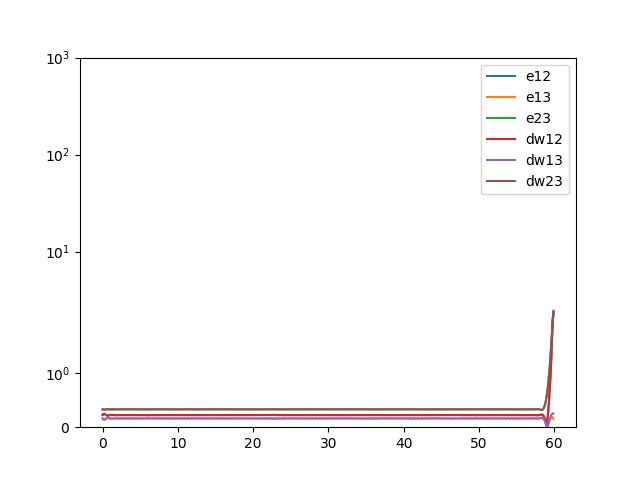

In [63]:
mode_comparaison = "GP"
if mode_comparaison == "MGPO":
    error_e = np.array(error_euclidian_MGPO)
    distance_w = np.array(distance_wasserstein_MGPO)
    error_w_diff = np.array(error_wasserstein_diff_MGPO)
    
if mode_comparaison == "GP":
    error_e = np.array(error_euclidian_GP)
    distance_w = np.array(distance_wasserstein_GP)
    error_w_diff = np.array(error_wasserstein_diff_GP)
    
print("Mean e: ", np.mean(error_e[:,0]),np.mean(error_e[:,1]),np.mean(error_e[:,2]))
print("Variance e: ", np.std(error_e[:,0]),np.std(error_e[:,1]),np.std(error_e[:,2]))
print("Mean w: ", np.mean(error_w_diff[:,0]),np.mean(error_w_diff[:,1]),np.mean(error_w_diff[:,2]))
print("Variance w: ", np.std(error_w_diff[:,0]),np.std(error_w_diff[:,1]),np.std(error_w_diff[:,2]))
diff_e_w = error_e[:,0:3]-error_w_diff

plt.figure(0)
plt.plot(T_prediction, error_e[:,0], label="e12")
plt.plot(T_prediction, error_e[:,1], label="e13")
plt.plot(T_prediction, error_e[:,2], label="e23")
#plt.plot(T_prediction,distance_w[:,0], label="w12")
#plt.plot(T_prediction, distance_w[:,1], label="w13")
#plt.plot(T_prediction, distance_w[:,2], label="w23")
plt.plot(T_prediction, error_w_diff[:,0], label="dw12")
plt.plot(T_prediction, error_w_diff[:,1], label="dw13")
plt.plot(T_prediction, error_w_diff[:,2], label="dw23")
ax = plt.gca()
ax.set_yscale('symlog')
plt.legend(loc='best')
ax.set_ylim([0, 1000])
plt.show()

In [64]:
# Error ground truth vs trajectory predicted

if mode_comparaison == "MGPO":
    Prediction_1 = Prediction_1_MGPO
    Prediction_2 = Prediction_2_MGPO
    Prediction_3 = Prediction_3_MGPO
    
if mode_comparaison == "GP":
    Prediction_1 = Prediction_1_GP
    Prediction_2 = Prediction_2_GP
    Prediction_3 = Prediction_3_GP

time_theoric_1 = []
time_theoric_2 = []
time_theoric_3 = []
error_theoric_1 = []
error_theoric_2 = []
error_theoric_3 = []
position_theoric_1 = []
position_theoric_2 = []
position_theoric_3 = []
for i,j,k in zip(Prediction_1,Prediction_2,Prediction_3):
    index_1 = GPf.find_nearest(time_trimble_1, i[0])
    index_2 = GPf.find_nearest(time_trimble_2, j[0])
    index_3 = GPf.find_nearest(time_trimble_3, k[0])
    if(abs(time_trimble_1[index_1]-i[0])<0.1):
        time_theoric_1.append(time_trimble_1[index_1])
        position_theoric_1.append(trimble_1[0:3,index_1])
        error_1 = np.linalg.norm(i[1:4]-trimble_1[0:3,index_1])*1000
        error_theoric_1.append(error_1)
    if(abs(time_trimble_2[index_2]-j[0])<0.1):
        time_theoric_2.append(time_trimble_2[index_2])
        position_theoric_2.append(trimble_2[0:3,index_2])
        error_2 = np.linalg.norm(j[1:4]-trimble_2[0:3,index_2])*1000
        error_theoric_2.append(error_2)
    if(abs(time_trimble_3[index_3]-k[0])<0.1):
        time_theoric_3.append(time_trimble_3[index_3])
        position_theoric_3.append(trimble_3[0:3,index_3])
        error_3 = np.linalg.norm(k[1:4]-trimble_3[0:3,index_3])*1000
        error_theoric_3.append(error_3)
#print(index_1,index_2,index_3)

Mean e (mm):  7.091153742594335 7.040999613913529 7.04635735354546
Variance e (mm):  59.67346569694298 59.27720231604105 59.331787774049445


<IPython.core.display.Javascript object>


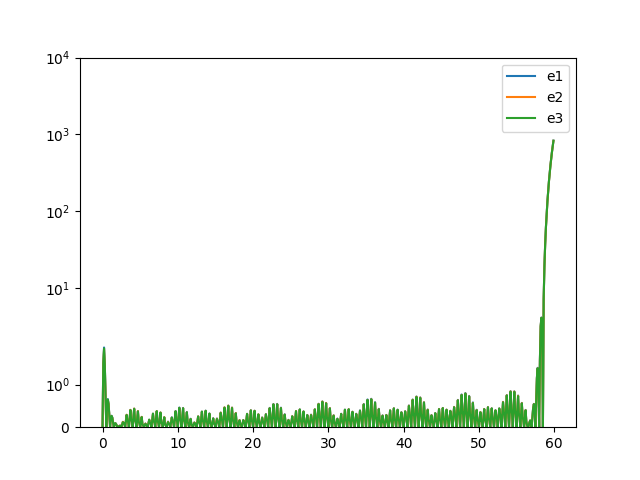

In [65]:
%matplotlib notebook
time_theoric_arr_1 = np.array(time_theoric_1)
time_theoric_arr_2 = np.array(time_theoric_2)
time_theoric_arr_3 = np.array(time_theoric_3)
error_theoric_arr_1 = np.array(error_theoric_1)
error_theoric_arr_2 = np.array(error_theoric_2)
error_theoric_arr_3 = np.array(error_theoric_3)
print("Mean e (mm): ", np.mean(error_theoric_arr_1),np.mean(error_theoric_arr_2),np.mean(error_theoric_arr_3))
print("Variance e (mm): ", np.std(error_theoric_arr_1),np.std(error_theoric_arr_2),np.std(error_theoric_arr_3))
plt.figure(0)
plt.plot(time_theoric_arr_1, error_theoric_arr_1, label="e1")
plt.plot(time_theoric_arr_2, error_theoric_arr_2, label="e2")
plt.plot(time_theoric_arr_3, error_theoric_arr_3, label="e3")
ax = plt.gca()
ax.set_yscale('symlog')
plt.legend(loc='best')
ax.set_ylim([0, 10000])
plt.show()

<IPython.core.display.Javascript object>


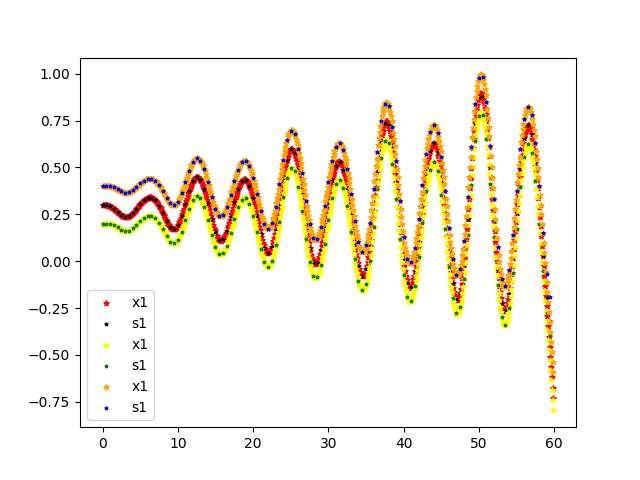

In [66]:
%matplotlib notebook
plt.figure(0)
coord = 2
plt.scatter(time_theoric_arr_1, np.array(Prediction_1)[:,coord+1], label="x1", marker="*", s = 15, color="r")
plt.scatter(time_sub_1, sub_1[coord], label="s1", marker="*", s = 5, color="black")
plt.scatter(time_theoric_arr_2, np.array(Prediction_2)[:,coord+1], label="x1", marker="*", s = 15, color="yellow")
plt.scatter(time_sub_2, sub_2[coord], label="s1", marker="*", s = 5, color="green")
plt.scatter(time_theoric_arr_3, np.array(Prediction_3)[:,coord+1], label="x1", marker="*", s = 15, color="orange")
plt.scatter(time_sub_3, sub_3[coord], label="s1", marker="*", s = 5, color="blue")
#plt.scatter(time_theoric_arr_1, np.array(theoric_1)[:,0], label="r1", marker="*", s=5)
#plt.scatter(time_trimble_1, trimble_1[0,:], label="t1", marker="*", s=5)

#plt.plot(time_theoric_arr_2, error_theoric_arr_2, label="e2")
#plt.plot(time_theoric_arr_3, error_theoric_arr_3, label="e3")
ax = plt.gca()
#ax.set_yscale('symlog')
plt.legend(loc='best')
#ax.set_ylim([0, 100])
plt.show()    

In [36]:
begin = 0
end = 60
rate = 20  #Hz
T_prediction_init = np.atleast_2d(np.arange(begin, end, 1/rate)).T

begin = 0
end = 40
rate = 100 
t = np.atleast_2d(np.arange(begin, end, 1/rate)).T

#begin = 0  #s
#end = 40  #s               # Traj 1: 1000, Traj 2: 500
#hz = 100    #Hz             # Traj 1: 20, Traj 2:100
#t = np.linspace(begin, end, (end-begin+1)*hz)

plt.scatter(T_prediction_init, T_prediction_init, label="r1", marker="*", s=10)
plt.scatter(t, t, label="r2", marker="*", s=3)

#plt.plot(time_theoric_arr_1, time_theoric_arr_1, label="x1", marker="*", markersize=10)
#plt.plot(time_trimble_1[0:100], time_trimble_1[0:100], label="t1", marker="*")
ax = plt.gca()
#ax.set_yscale('symlog')
plt.legend(loc='best')
#ax.set_ylim([0, 100])
plt.show()  

<IPython.core.display.Javascript object>


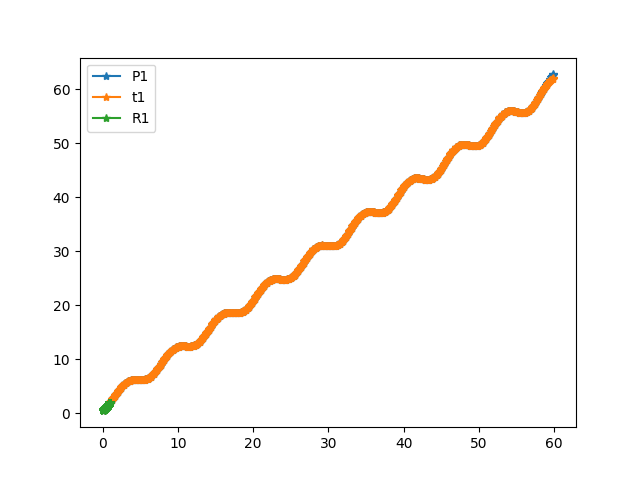

In [67]:
%matplotlib notebook
plt.figure(0)
plt.plot(np.array(Prediction_1)[:,0], np.array(Prediction_1)[:,1], label="P1", marker="*")
plt.plot(time_theoric_arr_1, np.array(position_theoric_1)[:,0], label="t1", marker="*")
plt.plot(time_trimble_1[0:966], trimble_1[0,0:966], label="R1", marker="*")

#plt.plot(time_theoric_arr_2, error_theoric_arr_2, label="e2")
#plt.plot(time_theoric_arr_3, error_theoric_arr_3, label="e3")
ax = plt.gca()
#ax.set_yscale('symlog')
plt.legend(loc='best')
#ax.set_ylim([0, 100])
plt.show()    

<IPython.core.display.Javascript object>


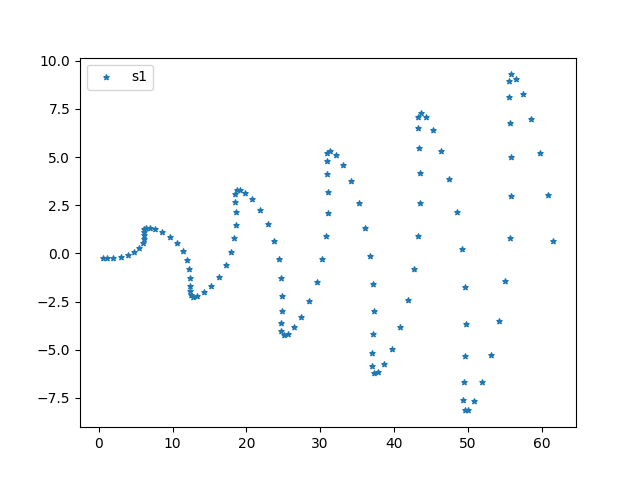

In [38]:
%matplotlib notebook
plt.figure(0)
plt.scatter(sub_1[0], sub_1[1], label="s1", marker="*", s = 15)
ax = plt.gca()
#ax.set_yscale('symlog')
plt.legend(loc='best')
#ax.set_ylim([0, 100])
plt.show()    